In [361]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize, Bounds
import plotly.express as px
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
# импортируем генераторы процессов с разными рычагами и KL метрику
from leverage_functions_and_metrics import gen_e, gen_gjr, gen_poly, gen_t, gen_lin,gen_multy_poly, multy_poly_leverage  
from leverage_functions_and_metrics import l_e, l_gjr, l_poly, l_t, KL, expectation_2m_
import time
import warnings
# warnings.filterwarnings('ignore')

## Сгенерируем данные с помощью GARCH с рычага с линейными комбинациями существующих

In [363]:
np.random.seed(42)
n = 1000
nu = np.random.normal(0,1, n)
x_lin = np.array([0.118, 0.24, 0.319, 0.286, -0.25, 0.441, -0.24, 0.32, -0.28 ,0.13, -0.145, 0.15, 0.58, 0.9])
sigma_lin = gen_lin(x_lin, nu)

In [364]:
eps = sigma_lin*nu

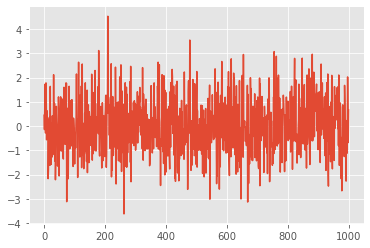

In [365]:
sns.lineplot(x=range(n), y=eps);

## С помощью ММП оценим параметры EGARCH, EGARCH c полиномиальным рычагом, TGARCH, GJR-GARCH

In [366]:
# EGARCH
bnds = Bounds(-2,2)
opts = {'maxiter' : 1000}
x0 = np.array([0.2,0.3,0.1, -0.5, 0.9])
res_e = minimize(l_e, x0=x0, args=(eps), method='trust-constr', bounds=bnds, options=opts)
x_e = res_e.x

C:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [367]:
res_e.success

True

In [368]:
# EGARCH with polynomial leverage
bnds = Bounds(-2,2)
opts = {'maxiter' : 1000}
x0 = np.array([0.2,0.3,0.1, -0.5,0.15, 0.9])
res_poly = minimize(l_poly, x0=x0, args=(eps), method='trust-constr', bounds=bnds, options=opts)
x_poly = res_poly.x

In [369]:
res_poly.success

True

In [370]:
# GJR-GARCH 
bnds = Bounds(-2,2)
opts = {'maxiter' : 1000}
x0 =  np.array([0.02,0.03,0.01, 0.05, 0.9])
res_gjr = minimize(l_gjr, x0=x0, args=(eps), method='trust-constr', bounds=bnds, options=opts)
x_gjr = res_gjr.x

In [371]:
res_gjr.success

True

In [372]:
# TGARCH 
bnds = Bounds(-2,2)
opts = {'maxiter' : 1000}
x0 = np.array([0.2,0.3,0.1, -0.5, 0.9])
res_t = minimize(l_t, x0=x0, args=(eps), method='trust-constr', bounds=bnds, options=opts)
x_t = res_t.x

## На основе полученных оценок сгенерируем волатильости процессов

In [373]:
# EGARCH
nu_e = np.array([np.nan]*n)
logsigma_e2 = np.array([np.nan]*n)
logsigma_e2[0] = np.log(x_e[-1]**2)
w_e = x_e[0]
a_e = x_e[1]
b_e = x_e[2]
theta_e = x_e[3]
nu_e[0] = eps[0]/np.sqrt(np.exp(logsigma_e2[0]))
for t in range(1,n):
    logsigma_e2[t] = w_e + a_e*(theta_e*nu_e[t-1] + ( abs(nu_e[t-1])-np.sqrt(2/np.pi) )) + b_e*logsigma_e2[t-1]
    nu_e[t] = eps[t]/np.sqrt(np.exp(logsigma_e2[t]))
sigma_e = np.sqrt(np.exp(logsigma_e2))

In [374]:
# EGARCH с полиномиальным рычагом
nu_p = np.array([np.nan]*n)
logsigma_poly2 = np.array([np.nan]*n)
logsigma_poly2[0] = np.log(x_poly[-1]**2)
w_p = x_poly[0]
a_p = x_poly[1]
b_p = x_poly[2]
theta_p1 = x_poly[3]
theta_p2 = x_poly[4]
nu_p[0] = eps[0]/np.sqrt(np.exp(logsigma_poly2[0]))
for t in range(1,n):
    logsigma_poly2[t] = w_p + theta_p1*nu_p[t-1] + theta_p2*(nu_p[t-1]**2-1) + b_p*logsigma_poly2[t-1]
    nu_p[t] = eps[t]/np.sqrt(np.exp(logsigma_poly2[t]))
sigma_poly = np.sqrt(np.exp(logsigma_poly2))

In [375]:
# GJR-GARCH
nu_gjr = np.array([np.nan]*n)
logsigma_gjr2 = np.array([np.nan]*n)
logsigma_gjr2[0] = np.log(x_gjr[-1]**2)
w_gjr = x_gjr[0]
a_gjr = x_gjr[1]
b_gjr = x_gjr[2]
theta_gjr = x_gjr[3]
nu_gjr[0] = eps[0]/np.sqrt(np.exp(logsigma_gjr2[0]))
for t in range(1,n):
    logsigma_gjr2[t] = w_gjr + (a_gjr +theta_gjr * (eps[t-1]<0))*eps[t-1]**2 + b_gjr*logsigma_poly2[t-1]
    nu_gjr[t] = eps[t]/np.sqrt(np.exp(logsigma_gjr2[t]))
sigma_gjr = np.sqrt(np.exp(logsigma_gjr2))

In [376]:
# TGARCH
nu_t = np.array([np.nan]*n)
logsigma_t2 = np.array([np.nan]*n)
logsigma_t2[0] = np.log(x_t[-1]**2)
w_t = x_t[0]
b_t = x_t[1]
theta_plus_t = x_t[2]
theta_minus_t = x_t[3]
nu_t[0] = eps[0]/np.sqrt(np.exp(logsigma_t2[0]))
for t in range(1,n):
    logsigma_t2[t] = w_t + theta_plus_t*eps[t-1]*(eps[t-1]>=0) - theta_minus_t*eps[t-1]*(eps[t-1]<0) + b_t*logsigma_t2[t-1]
    nu_t[t] = eps[t]/np.sqrt(np.exp(logsigma_t2[t]))
sigma_t = np.sqrt(np.exp(logsigma_t2))

In [377]:
# Соберем волатильности в матрицу
sigma_m = np.array([sigma_e, sigma_poly, sigma_gjr, sigma_t])

## Model Averaging Estimator for Conditional Volatility

## $\hat{h}_t = \sum_{m=1}^M w_m \sigma_{m,t}^2$

## $\varepsilon_t = \hat{h}_t^{1/2} \eta_t$ ~ N(0, $\hat{h}_t$)

## где $\eta_i$ ~ $i.i.d. N(0,1)$


## Далее выписываем ММП и оптимизируем по $w_m|_{m=1}^M$

In [378]:
w_m = np.array([1/sigma_m.shape[0]]*sigma_m.shape[0])

In [379]:
def l_w(w, sigma_m, eps, lambda_):
    #n = len(eps)
    return 0.5*np.sum(np.log(w@sigma_m**2)) + np.sum(eps/(2*w@sigma_m**2)) + lambda_*np.sum(np.abs(w*w)) #+n*np.log(2*np.pi)*0.5  

In [394]:
l_w(w_m,sigma_m, eps,10)

122.93304026494779

In [381]:
eq_cons = {'type': 'eq',
           'fun': lambda x: np.array ([x[0]+x[1]+x[2]+x[3] - 1]),
           'jac': lambda x: np.array ([1.0,1.0,1.0,1])
          }

In [495]:
bounds = Bounds(0,1)
x0 = w_m
res = minimize(l_w, 
               x0, 
               args=(sigma_m,eps,5000), method='SLSQP',
               constraints=[eq_cons], 
               options={'ftol': 1e-9, 'disp': True},
               bounds=bounds)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1370.4328573466155
            Iterations: 3
            Function evaluations: 23
            Gradient evaluations: 3


In [496]:
res

     fun: 1370.4328573466155
     jac: array([2990.14915466, 2990.14915466, 2990.14912415, 2990.1491394 ])
 message: 'Optimization terminated successfully'
    nfev: 23
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([0.2498964, 0.250098 , 0.2500929, 0.2499127])

In [497]:
sigma_teta = np.sqrt(res.x@sigma_m**2)

In [498]:
print('KL дивергенция для полученных оценок',
      np.sum(-1/2 - np.log(sigma_lin)+np.log(sigma_teta)+0.5*(sigma_lin/sigma_teta)**2))

KL дивергенция для полученных оценок 3.951992411817874


In [499]:
# EGARCH
np.sum(-1/2 - np.log(sigma_lin)+np.log(sigma_e)+0.5*(sigma_lin/sigma_e)**2)

3.848589831584363

In [500]:
# TGARCH
np.sum(-1/2 - np.log(sigma_lin)+np.log(sigma_t)+0.5*(sigma_lin/sigma_t)**2)

3.9734436818526255

In [501]:
# GJR GARCH
np.sum(-1/2 - np.log(sigma_lin)+np.log(sigma_gjr)+0.5*(sigma_lin/sigma_gjr)**2)

4.3788575549888336

In [502]:
# EGARCH poly
np.sum(-1/2 - np.log(sigma_lin)+np.log(sigma_poly)+0.5*(sigma_lin/sigma_poly)**2)

4.639583095059965